In [1]:
import scanpy as sc 
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import matplotlib as mpl
import numpy as np
import scipy
import os
import re

from utils import plot_histogram
from var import sc_data_w_cas9_seq_folder, results_folder, today, color

In [2]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [3]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/cas9_count/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Load .h5ad and mapping file </h3>

In [4]:


def read_10x_output(file_path, smp_list, metadata=None, type = 'raw', umi_filter=5):
    import os
    
    #Writing output from separate samples, processed using CellRanger, into a dictionary of Scanpy objects:
    ad = {}

    #Generate AnnData for each sample
    for sample_name in smp_list:
        path = file_path + sample_name
        for i in os.listdir(path):
            #filter for raw and filtered files
            if i==f'{type}_feature_bc_matrix':
                mtx_folder = i
        #read in matrix, features and barcodes
        mtx_folder_path = f'{file_path}{sample_name}/{mtx_folder}/'
        adata_init = sc.read_mtx(f'{mtx_folder_path}matrix.mtx.gz')
        #data wrangling for features_df to have the same format and column headers as if it is read with sc.read_10x_h5()
        features_df = features_df = pd.read_csv(f'{mtx_folder_path}features.tsv.gz', sep='\t', header=None, names=['gene_ids', 'gene_names', 'feature_types', 'genome'])
        features_df = features_df.set_index('gene_names')
        features_df['genome'] = 'GRCh38'
        
        barcodes_df = pd.read_csv(f'{mtx_folder_path}barcodes.tsv.gz', sep='\t', header=None, names=['barcodes'])
        
        #check if count matrix needs to be transposed
        if adata_init.shape[0] == features_df.shape[0]:
            #transpose the matrix to correct for dimensionality 
            adata = anndata.AnnData(X=adata_init.X.T.copy(), obs=barcodes_df, var=features_df)
        else:
            adata = anndata.AnnData(X=adata_init.X.copy(), obs=barcodes_df, var=features_df)
        ad[sample_name] = adata
        ad[sample_name].var.rename(columns = {'gene_ids':'ENSEMBL'}, inplace = True)
        ad[sample_name].var['SYMBOL'] = ad[sample_name].var.index
        ad[sample_name].var.index = ad[sample_name].var['ENSEMBL']
        ad[sample_name].var.drop(columns=['ENSEMBL'], inplace=True)
        #ad[sample_name].var_names_make_unique() 
        
        
        sc.pp.calculate_qc_metrics(ad[sample_name], inplace=True)
        ad[sample_name] = ad[sample_name][ad[sample_name].obs['total_counts'] > umi_filter, :]
        ad[sample_name].var['mt'] = [gene.startswith('mt-') 
                                     for gene in ad[sample_name].var['SYMBOL'].str.lower()]
        ad[sample_name].obs['mt_frac'] = (ad[sample_name][:, 
               ad[sample_name].var['mt'].tolist()].X.sum(1).A.squeeze() 
                                          / ad[sample_name].obs['total_counts'])
        
        ad[sample_name].obs['sample'] = sample_name
        ad[sample_name].obs['barcode'] = ad[sample_name].obs_names
        ad[sample_name].obs_names = ad[sample_name].obs['sample']+"_"+ad[sample_name].obs['barcode']

    #Merge AnnData objects from all the samples together    
    from scipy.sparse import vstack
    stack = vstack([ad[x].X for x in smp_list]) # stack data
    adata = sc.AnnData(stack, var = ad[smp_list[0]].var)
    adata.obs = pd.concat([ad[x].obs for x in smp_list], axis = 0)

    if metadata is not None:
        #Add cleaned metadata to the Anndata.obs table
        obs_merged = pd.merge(left = adata.obs, right = metadata, 
                              how = "left", left_on="sample", right_on="sample")
        obs_merged.index = obs_merged['sample']+"_"+obs_merged['barcode']
        print(obs_merged.index.equals(adata.obs.index))
        adata.obs = obs_merged

    return adata, ad



In [5]:
#Create a sample list in form of a dataframe to be concatenated by the read_10x_output function
sample_list = pd.DataFrame({
    'sample': ['cellranger710_count_b19be2297428467aff7e8f9089417af6']
})

In [6]:
#Initial data load

adata, ad_list = read_10x_output(
    sc_data_w_cas9_seq_folder, 
    smp_list=sample_list['sample'],
    metadata=sample_list, type = 'filtered')


/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_63529/2544536941.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad[sample_name].var['mt'] = [gene.startswith('mt-')


True


In [16]:
#create list of sequences detected on Cas9 and sgrna plasmids
#filter in var names for sequences not starting with ENSG
plasmid_seq = [x for x in adata.var_names if not x.startswith('ENSG')]

#exclude sgRNA sequences from cas9_seq using regex to match sgRNA sequences
plasmid_seq = [x for x in plasmid_seq if not re.match(r'(?=.*[ATGC]{20})(?=.*[ATGC]{20})', x)]

In [9]:
def subset_cells(
    adata,
    cells_per_category=10000,
    stratify_category_key='sample',
):
    
    adata.obs['_cell_index'] = np.arange(adata.n_obs)
    subset_ind = list()
    
    for ct in adata.obs[stratify_category_key].unique():
        ind = adata.obs[stratify_category_key] == ct
        subset_ind_ = adata.obs['_cell_index'][ind]
        n_samples = np.min((len(subset_ind_), cells_per_category))
        subset_ind = subset_ind + list(np.random.choice(subset_ind_, size=n_samples, replace=False))
    print(len(subset_ind))
    
    return adata[subset_ind, :].copy()

def compute_pcs_knn_umap(
    adata_subset, stratify_category_key='sample', 
    tech_category_key=None, plot_category_keys=list(), 
    scale_max_value=10, n_comps=100, n_neighbors=15,
):
    adata_subset.obs['total_counts'] = np.array(adata_subset.X.sum(1)).flatten()
    adata_subset.layers['counts'] = adata_subset.X.copy()
    # No normalisation by total count
    #does not normalise data effectively
    #proportionality errors if divide by total counts
    sc.pp.log1p(adata_subset)
    # Scale with no HVG selection
    if tech_category_key is None:
        sc.pp.scale(adata_subset, max_value=scale_max_value)
    else:
        for tech in adata_subset.obs[tech_category_key].unique():
            mu, std = compute_mu_std(adata_subset[adata_subset.obs[tech_category_key] == tech].X)
            adata_subset[adata_subset.obs[tech_category_key] == tech].X = (
                np.minimum((adata_subset[adata_subset.obs[tech_category_key] == tech].X - mu) / std, scale_max_value)
            )
    # A lot of PC dimensions
    sc.tl.pca(adata_subset, svd_solver='arpack', n_comps=n_comps, use_highly_variable=False)
    # Plot PCs to confirm that PC1 is indeed linked to total count
    # sc.pl.pca(adata_subset, color=['total_counts'],
    #           components=['1,2', '2,3', '4,5'],
    #           color_map = 'RdPu', ncols = 3, legend_loc='on data',
    #           legend_fontsize=10)
    plt.hist2d(adata_subset.obsm['X_pca'][:, 0].flatten(),
               adata_subset.obs['total_counts'].values.flatten(),
               bins=200,
               norm=mpl.colors.LogNorm());
    plt.xlabel('PC 1');
    plt.ylabel('Total RNA count');
 
    plt.savefig(f'{figures_folder}{today}_hist2d.pdf',bbox_inches='tight')
    plt.show()

    # Remove PC1 to remove technical variability
    adata_subset.obsm['X_pca'] = adata_subset.obsm['X_pca'][:, 1:]
    adata_subset.varm['PCs'] = adata_subset.varm['PCs'][:, 1:]

    # compute KNN and UMAP to see how well this represents the dataset
    sc.pp.neighbors(adata_subset, n_neighbors=n_neighbors)
    sc.tl.umap(adata_subset, min_dist = 0.4, spread = 1.5)

    # Plot UMAP
    sc.pl.umap(adata_subset, color=[stratify_category_key],
               color_map = 'RdPu', ncols = 3, #legend_loc='on data',
               legend_fontsize=10,
               frameon=False,
               show=False #show=False to avoid saving empty plots
               )
    plt.savefig(f'{figures_folder}{today}_sample_umap.pdf', bbox_inches='tight')
    return adata_subset

def compute_mu_std(X):
        
    mu = np.array(X.mean(0))
    mu_sq = mu ** 2
    X = X.copy()
    X.data = X.data ** 2
    sq_mu = np.array(X.mean(0))
    std = np.sqrt(sq_mu - mu_sq) + 1e-8
    
    return mu, std

In [10]:

cells_per_category=20000
stratify_category_key='sample'
tech_category_key=None


adata_subset = subset_cells(
    adata, cells_per_category=cells_per_category, 
    stratify_category_key=stratify_category_key,
)

12859


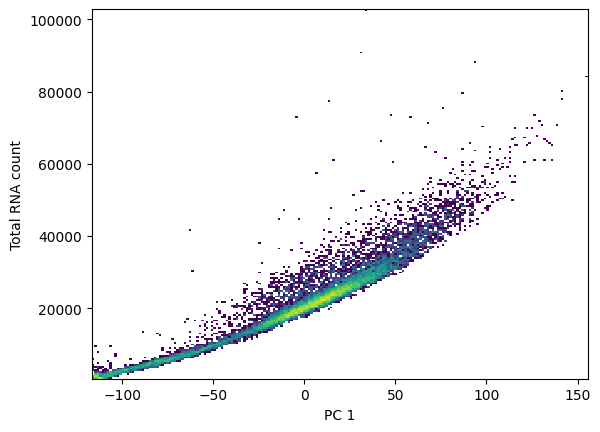

/nfs/team205/kl11/miniconda3/envs/bcftools/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


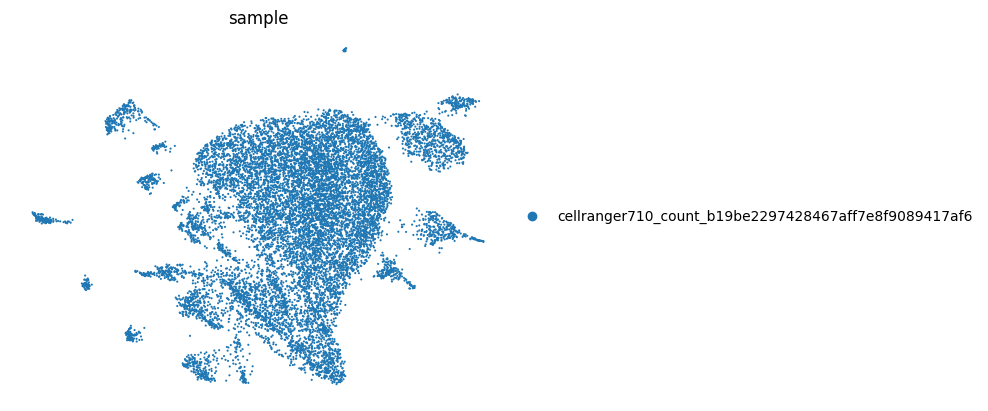

In [11]:
### Step 1.1 - compute PCs by apply standard workflow with a few exceptions ##
adata_subset = compute_pcs_knn_umap(
    adata_subset, 
    tech_category_key=None, plot_category_keys=None, 
    scale_max_value=10, n_comps=50, n_neighbors=15,
)

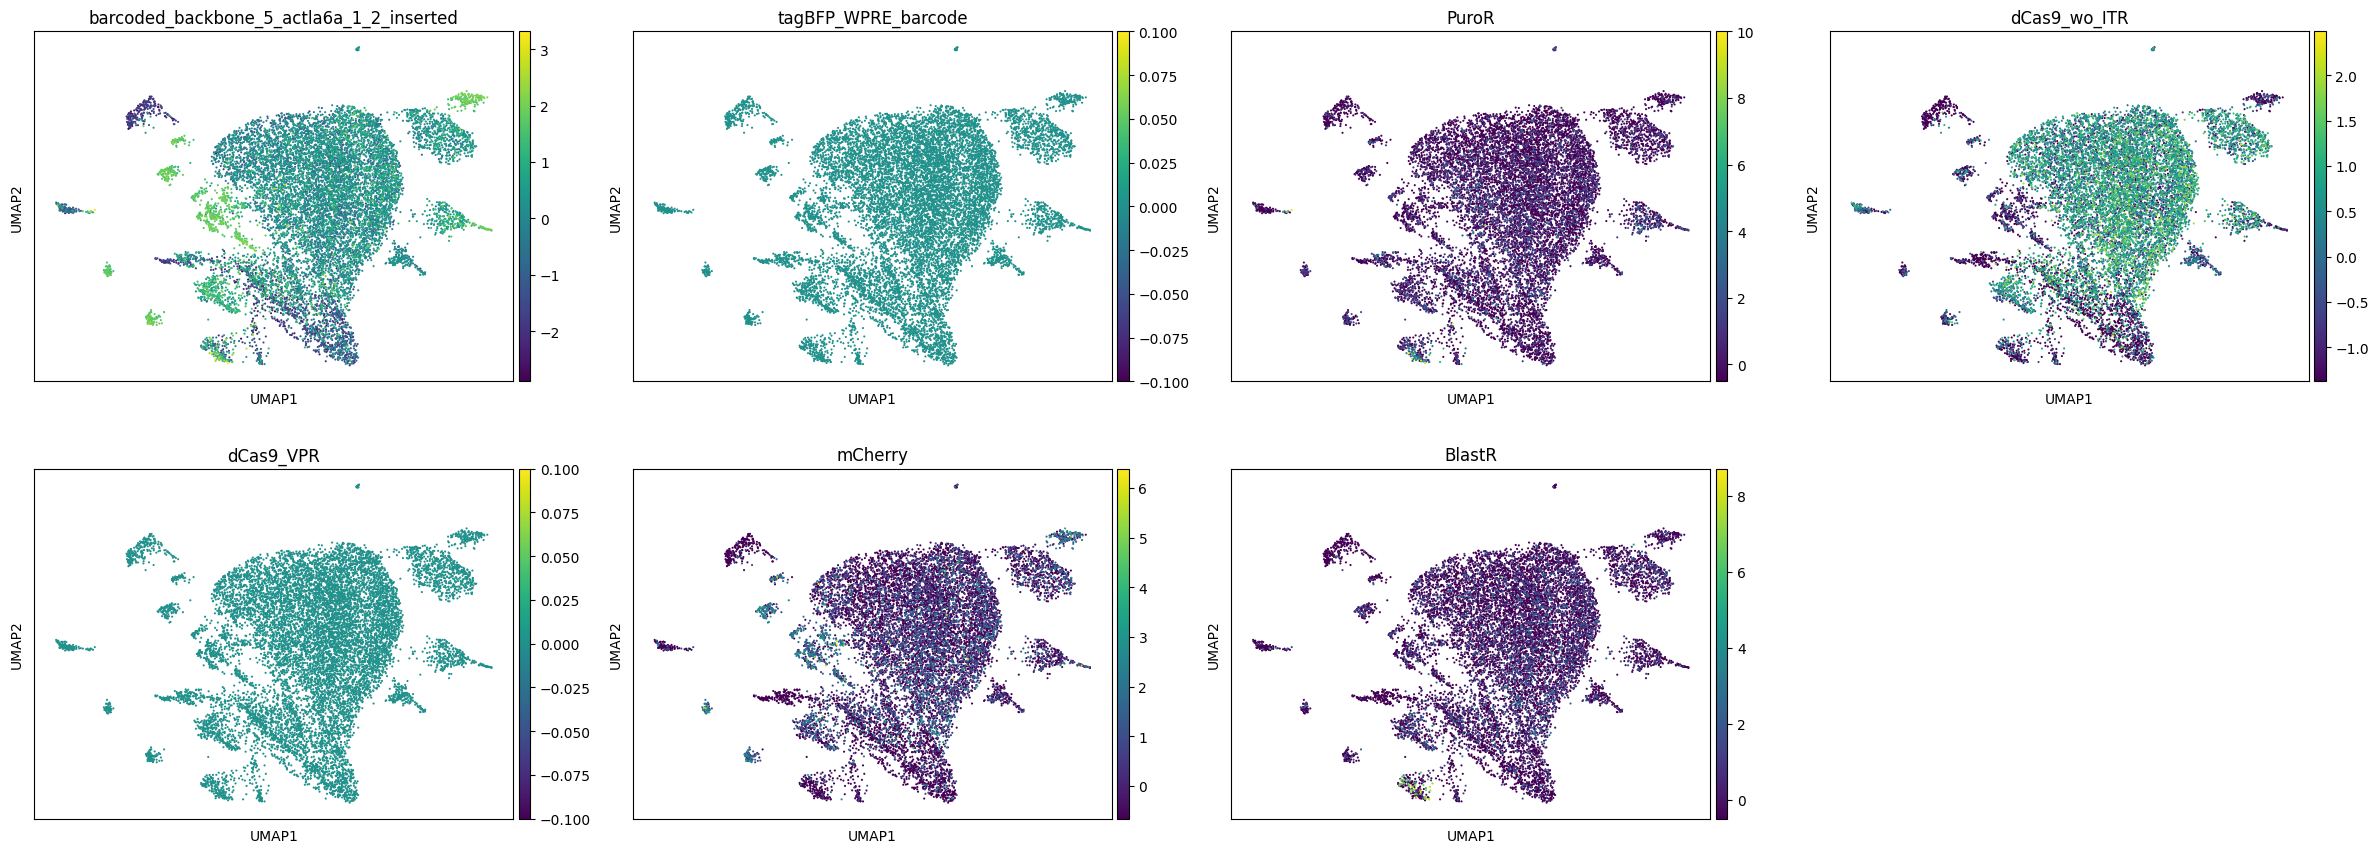

In [17]:
#plot umap for plasmid seq using adata
sc.pl.umap(adata_subset, color=plasmid_seq)